# Procrastinate Pro+

Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, необходимо разобраться в причинах сложившейся ситуации.

Исходные данные - лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нужно изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

## Изучение данных и подготовка к анализу

Исходные данные - данные о визитах, заказах и расходах. Цель первого шага - оптимизировать данные для анализа.
Путь к файлам:
* /datasets/visits_info_short.csv.
* /datasets/orders_info_short.csv.
* /datasets/costs_info_short.csv.

In [1]:
# импорт библиотек для работы с данными
import pandas as pd
import numpy as np

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# методы библиотеки datetime для работы с датами
from datetime import datetime, timedelta

In [2]:
# загрузка датасетов в переменные
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except FileNotFoundError:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')

Поочередно рассмотрим загруженные датасеты и разберем состав, типы и вид исходных данных

In [3]:
# функция вывода общей краткой информации о датасете

def df_info(df):
    display(df.sample(5))
    print(df.info())
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:')
    display(df.isna().sum())

In [4]:
df_info(visits)

,User Id,Region,Device,Channel,Session Start,Session End
221283,517735038141,Germany,PC,WahooNetBanner,2019-05-29 13:06:38,2019-05-29 15:04:02
49136,236264083216,United States,Mac,TipTop,2019-06-21 20:20:07,2019-06-21 20:37:19
248595,181768034200,France,iPhone,organic,2019-07-22 15:15:29,2019-07-22 16:06:40
286270,45996361330,France,PC,WahooNetBanner,2019-09-25 12:00:36,2019-09-25 12:21:12
297656,978155032384,Germany,PC,organic,2019-10-10 19:54:14,2019-10-10 19:59:10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Количество дубликатов: 0
Количество пропусков:


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

В датасете visits_log_short (лог сервера с информацией о посещениях сайта), согласно исходной документации, представлены следующие данные:

* User Id — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Session start — дата и время начала сессии
* Session End — дата и время окончания сессии
* Channel — идентификатор рекламного источника, из которого пришел пользователь
* Region - страна пользователя

По типам данных можно сразу сделать вывод, что столбцы с началом и концом сессии нужно привести к формату дат, столбцы region, channel, device так и должны остаться типом object, рассмотрим уникальные значения в столбцах.

In [5]:
# значения в столбце region

visits['Region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

По значениям можно сделать вывод, что информация представлена о пользователях из 4 регионов: США, UK, Франция и Германия.

In [6]:
# значения в столбце channel

visits['Channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [7]:
# значения в столбце device

visits['Device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

Сессии делятся на 4 категории по устройству, с которого зашел пользователь.

Здесь неявных дубликатов или ошибок в данных не наблюдается, перейдем к рассмотрению следующего датасета с информацией о заказах

In [8]:
df_info(orders)

,User Id,Event Dt,Revenue
38319,804079690050,2019-10-13 07:21:23,4.99
20286,764769879983,2019-09-26 20:48:44,4.99
36715,295795879965,2019-09-27 08:06:25,4.99
3858,750650056971,2019-06-17 05:14:58,4.99
27890,517696182112,2019-10-31 06:13:52,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Количество дубликатов: 0
Количество пропусков:


User Id     0
Event Dt    0
Revenue     0
dtype: int64

Согласно полученной справке, orders_log_short (информация о заказах), содержит следующие данные:

* User Id — уникальный id пользователя, который сделал заказ
* Event Dt — дата и время покупки
* Revenue — выручка

Столбец event dt необходимо привести к формату даты, остальные типы данных менять не нужно. Рассмотрим последний датасет.

In [9]:
df_info(costs)

,dt,Channel,costs
213,2019-06-03,MediaTornado,4.32
620,2019-07-20,TipTop,265.20
16,2019-05-17,FaceBoom,101.20
532,2019-10-20,RocketSuperAds,7.80
526,2019-10-14,RocketSuperAds,6.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Количество дубликатов: 0
Количество пропусков:


dt         0
Channel    0
costs      0
dtype: int64

Таблица costs_short (информация о затратах на маркетинг):

* Channel — идентификатор рекламного источника
* Dt — дата
* Costs — затраты на этот рекламный источник в этот день

Здесь аналогично датасету с выручкой, необходимо будет изменить тип данных в столбце с датами, остальные столбцы имеют правильный формат.

Рассмотрим уникальные значения столбца Channel и соответствуют ли они такому же столбцу в датасете visits

In [10]:
# значения в столбце channel датасета с затратами на маркетинг

costs['Channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Проверим, какие из значений столбца channel в датасете visits отсутствуют в списке уникальных значений датасета costs

In [11]:
for i in visits['Channel'].unique():
    if i in costs['Channel'].unique():
        continue
    else:
        print(i)

organic


Только органический трафик отсутствует в датасете с затратами на маркетинг, все остальные значения совпадают, что логично, так как данный трафик является бесплатным для бизнеса по своей сути.

Приведем названия столбцов к "змеиному" регистру и изменим типы данных для дат в датасетах

In [12]:
# изменение названий столбцов в датасетах

visits = visits.rename(columns={'User Id' : 'user_id', 'Session Start':'session_start', 'Session End':'session_end'})
visits.columns = visits.columns.str.lower()

orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt'})
orders.columns = orders.columns.str.lower()

costs.columns = costs.columns.str.lower()

In [13]:
# изменение форматов в столбцах с датами

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Еще раз взглянем на полученные датасеты

In [14]:
df_info(visits)

,user_id,region,device,channel,session_start,session_end
237934,376389645454,UK,iPhone,LeapBob,2019-07-01 11:06:46,2019-07-01 11:09:55
94236,541060588249,United States,Mac,YRabbit,2019-08-02 09:48:40,2019-08-02 09:54:12
172083,930051599511,United States,iPhone,TipTop,2019-10-03 22:06:20,2019-10-03 23:03:10
82894,984382679647,United States,iPhone,MediaTornado,2019-07-22 03:04:05,2019-07-22 03:22:27
143065,893687775167,United States,iPhone,FaceBoom,2019-09-13 10:55:40,2019-09-13 11:05:02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None
Количество дубликатов: 0
Количество пропусков:


user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [15]:
df_info(orders)

,user_id,event_dt,revenue
18562,126310507541,2019-09-18 15:25:50,4.99
15374,408840163738,2019-08-31 11:30:23,4.99
36469,294990567320,2019-09-24 14:36:04,4.99
35438,702354915229,2019-09-12 15:37:02,4.99
12334,449546533185,2019-08-13 10:44:45,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
None
Количество дубликатов: 0
Количество пропусков:


user_id     0
event_dt    0
revenue     0
dtype: int64

In [16]:
df_info(costs)

,dt,channel,costs
1789,2019-10-17,lambdaMediaAds,2.40
1579,2019-09-17,WahooNetBanner,24.00
1209,2019-09-07,LeapBob,9.45
545,2019-05-06,TipTop,78.00
167,2019-10-15,FaceBoom,163.90


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Количество дубликатов: 0
Количество пропусков:


dt         0
channel    0
costs      0
dtype: int64

_____
**Вывод**

Таким образом, мы передали переменным visits, orders, costs исходную информацию и выполнили следующие преобразования в датасетах:
- изменили названия столбцов в соответствии с "змеинным регистром";
- преобразовали столбцы с датами в формат datetime;
- рассмотрели уникальные значения столбца region, что позволило определить, что клиенты приложения из США, UK, Германии и Франции;
- рассмотрели уникальные значения столбца devices, что позволило определить виды устройств, с которых клиенты заходили в приложение: iPhone, Mac, Android, PC;
- рассмотрели соответствие уникальных каналов трафика и их соответствие в двух датасетах (visits и costs). Каких-либо аномалий и ошибок в данных выявлено не было;

Для того, чтобы проанализировать и выявить причины убыточной маркетинговой стратегии, необходимо рассчитать бизнес-метрики. Для этого зададим функции по их расчету следующим шагом исследования.
____

## Функции расчета бизнес-метрик: LTV, ROI, удержание, конверсия

Чтобы оценить качество клиентов, применим когортный анализ, в нашем датасете профили пользователей можно делить по различным признакам во времени. В нашем распоряжении лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

Необходимые параметры для формирования когорт у нас имеются, это время события (регистрация пользователя), а также дополнительные признаки (страна проживания, канал привлечения, тип устройства).

В данном пункте зададим функции, которые будут рассчитывать необходимые для анализа метрики, на основе переданных в функции данных.

### Retention rate (удержание пользователей)

Коэффициент удержания пользователей показывает, сколько пользователей из когорты (группы пользователей, объединенных по общему событию и признакам) относительно начального числа вернулись, то есть воспользовались приложением Procrastinate Pro+ в последующие периоды.
Расчитывается по формуле: Количество активных пользователей на текущий день / Количество активных пользователей на первый день.

Для начала напишем функцию создания датасета с профилями пользователей, в ней сразу учтем CAC - траты на привлечение клиента, для расчета ROI

In [17]:
# ФУНКЦИЯ СОЗДАНИЯ ПРОФИЛЕЙ ПОЛЬЗОВАТЕЛЕЙ
def get_profiles(visits, orders, costs):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения временных и дополнительных характеристик
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first', 
                'channel': 'first',
                'device': 'first',
                'region': 'first'
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # добавляем столбец payer, где True - если пользователь тратил деньги в приложении
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # считаем количество уникальных пользователей с одинаковым каналом прихода
    # и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id':'nunique'})
        # переименование столбца
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    # объединение затрат на привлечение и число привлеченных пользователей
    # по датам и каналам привлечения
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавление стоимости привлечения (столбец ac) в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )
    
    # заполнение ячеек с тратами на пользователей по каналу organic нулями
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

Получив данные о профилях пользователей, можем написать функцию для расчета Retention rate, с учетом момента и горизонта анализа.

На выходе функции мы получим 3 таблицы: "сырые" данные, таблицу удержания, таблицу динамики удержания

In [18]:
# ФУНКЦИЯ РАСЧЕТА RR И ДИНАМИКИ RR
def get_retention(profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # столбец payer добавляем к списку для группировки пользователей
    dimensions = ['payer'] + dimensions
    
    # исключение из анализа пользователей не входящих в горизонт анализа
    last_acquisition_date = observation_date
    if not ignore_horizon:
        last_acquisition_date = observation_date - timedelta(days=horizon_days -1)
    result_raw = profiles.query('dt <= @last_acquisition_date')
    
    # сбор "сырых" данных для расчета удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    # расчет лайфтайма (лайфтайм - количество дней жизни пользователей 
    # после регистрации, в нашем случае с первой сессии)
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # группировка по признакам (demensions)
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size']+list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получение таблицы удержания (с расчитанным retention rate)
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получение таблицы динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    # возвращение результата - таблица удержания, таблица динамики удержания
    # и "сырые" данные
    return result_raw, result_grouped, result_in_time

### Conversion rate (конверсия)

Конверсия - процент пользователей когорты, совершивших определенное действие (в нашем случае это может быть регистрация в приложении, совершение первой покупки в приложении Procrastinate Pro+).

В данном случае для расчета необходима информация из датасета orders о покупках пользователей.

На выходе функции получаем по аналогии с расчетом удержания 3 таблицы: сырые данные, конверсия, динамика конверсии

In [19]:
# ФУНКЦИЯ РАСЧЕТА CR И ДИНАМИКИ CR
def get_conversion(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # исключение из анализа пользователей не входящих в горизонт анализа
    last_acquisition_date = observation_date
    if not ignore_horizon:
        last_acquisition_date = observation_date - timedelta(days=horizon_days -1)
    result_raw = profiles.query('dt <= @last_acquisition_date')
    
    # определение даты и времени первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt':'first'})
        .reset_index()
    )
    
    # добавление данных о покупках в профили пользователей
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    
    # расчет лайфтайма для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # костыль для группировки, если не указаны дополнительные признаки
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All'
        dimensions = dimensions + ['cohort']
    
    # функция для группировки по признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # расчет конверсии (деление каждой ячейки таблицы на размер когорты)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получение таблицы конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # очистка от костыля для таблицы динамики конверсии
    if 'cohort' in dimensions:
        dimensions = []
        
    # таблица динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращение таблиц и сырых данных
    return result_raw, result_grouped, result_in_time

### LTV и ROI (пожизненная ценность клиента и окупаемость инвестиций)

Следующая функция позволит рассчитать LTV, динамику LTV, ROI и динамику ROI.

LTV - это пожизненная ценность клиента, то есть общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. В нашем случае это общая сумма денег с покупок в приложении Procrastinate Pro+. Она также измеряется за определенный срок, это может быть день, неделя, месяц после регистрации пользователя в системе. LTV также является числителем показателя ROI

Второй параметр, который необходим для расчета ROI, является CAC (customer acquisition cost) - стоимость привлечения одного клиента. В нашем случае, это маркетинговые вложения в канал, откуда пришел клиент.

ROI (return of investment) - это окупаемость инвестиций. Данная метрика показывает, на сколько пожизненная ценность клиента превышает расходы на его привлечение.

Здесь в функцию добавится информация из датасета, получаемого из функции profiles, столбец aqcuisition_cost - стоимость привлечения клиента.

In [20]:
# ФУНКЦИЯ РАСЧЕТА LTV, ROI И ДИНАМИКИ LTV, ROI
def get_ltv_roi(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):
    
    # исключение пользователей вне горизонта анализа
    last_acquisition_date = observation_date
    if not ignore_horizon:
        last_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_acquisition_date')
    
    # добавление информации о покупках
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # расчет лайфтайма пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # костыль для группировки по общему признаку cohort, если нет дополнительных признаков
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All'
        dimensions = dimensions + ['cohort']
        
    # функция расчета ltv и roi
    def group_by_dimensions(df, dims, horizon_days):
        ltv = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # вычисление суммы выручки с накоплением
        ltv = ltv.fillna(0).cumsum(axis=1)
        # размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        # объединение выручки с размерами когорт
        ltv = cohort_sizes.merge(ltv, on=dims, how='left').fillna(0)
        # рассчет LTV
        ltv = ltv.div(ltv['cohort_size'], axis=0)
        # исключение лайфтаймов вне горизонта анализа
        ltv = ltv[['cohort_size'] + list(range(horizon_days))]
        ltv['cohort_size'] = cohort_sizes
        
        # расчет CAC
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        # расчет ROI
        roi = ltv.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        
        roi['cohort_size'] = cohort_sizes
        
        # сведение таблицы
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        # возвращение таблиц LTV и ROI
        return ltv, roi
    
    # получение таблиц LTV и ROI
    ltv_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # создание таблиц динамики LTV и ROI
    if 'cohort' in dimensions:
        dimensions = []
    
    ltv_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return (
        result_raw, # сырые данные
        ltv_grouped, # таблица LTV
        ltv_in_time, # динамика LTV
        roi_grouped, # таблица ROI
        roi_in_time # динамика ROI
    )

Таким образом, мы определили функции для расчета основных метрик, используемых в анализе эффективности маркетинга в части привлечения и удержания новых пользователей.

Для визуализации результатов также напишем функции визуализации показателей с различными входными данными

### Визуализация метрик

In [21]:
# визуализация Retention rate

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [22]:
# визуализация Conversion Rate

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [23]:
# визуализация LTV, ROI, CAC

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(25, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
# расчет скользящего среднего для избавления от шумов в графиках

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

___
**Вывод**

Мы описали основные метрики, которые будут использоваться в следующем шаге - исследовательском анализе данных, а также прописали код функций для их расчета.

Для того, чтобы определить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей, будем расчитывать следующие метрики:

- Retention rate (удержание пользователей)
- Conversion rate (конверсия)
- LTV (пожизненная ценность клиента)
- ROI (окупаемость инвестиций)
___

## Исследовательский анализ данных

Построим профили пользователей и определим максимальную и минимальную дату привлечения пользователей.

В рамках исследования ответим на следующие вопросы:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [25]:
# получение профилей пользователей

profiles = get_profiles(visits, orders, costs)
display(profiles.sample(5))
print('Количество пользователей в рассматриваемом периоде: {} человек'.format(profiles['user_id'].nunique()))

,user_id,first_ts,channel,device,region,payer,dt,month,acquisition_cost
132805,885858339074,2019-08-10 18:47:25,LeapBob,iPhone,UK,False,2019-08-10,2019-08-01,0.206441
35233,234012068287,2019-08-08 18:26:18,WahooNetBanner,Android,France,False,2019-08-08,2019-08-01,0.612500
24492,163449474917,2019-08-04 10:33:18,FaceBoom,Mac,United States,False,2019-08-04,2019-08-01,1.105612
7923,52916584764,2019-05-08 23:48:38,TipTop,iPhone,United States,False,2019-05-08,2019-05-01,0.982759
138880,926256152239,2019-08-18 06:35:05,FaceBoom,iPhone,United States,False,2019-08-18,2019-08-01,1.126442


Количество пользователей в рассматриваемом периоде: 150008 человек


In [26]:
print('Количество платящих пользователей: {}'.format(profiles[profiles['payer']==True]['user_id'].nunique()))
print('Количество не платящих пользователей: {}'.format(profiles[profiles['payer']==False]['user_id'].nunique()))

Количество платящих пользователей: 8881
Количество не платящих пользователей: 141127


По написанной в предыдущем шаге функции мы получили профили пользователей, выясним минимальную и максимальную дату привлечения

In [27]:
print('Минимальная дата привлечения {}'.format(profiles['dt'].min()))
print('Максимальная дата привлечения {}'.format(profiles['dt'].max()))

Минимальная дата привлечения 2019-05-01
Максимальная дата привлечения 2019-10-27


Даты соответствуют периодам регистрации пользователей, минимальная дата - 01 мая 2019 года, последний зарегистрированный пользователь - 27 октября 2019 года.

Рассмотрим, как 150 тысяч новых пользователи делятся по географическому положению

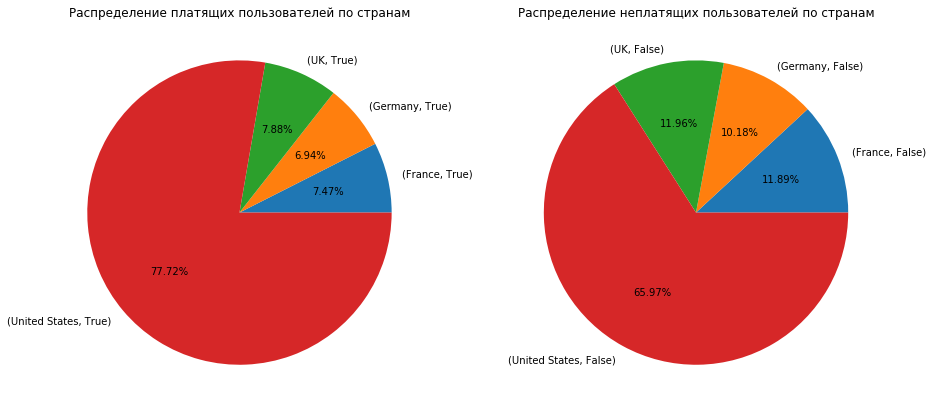

In [28]:
# построение pie по регионам

plt.figure(figsize=(15,10))
regions_chart = profiles.pivot_table(index=['region','payer'], values='user_id', aggfunc='count')

ax1 = plt.subplot(1,2,1)
regions_chart.query('payer == True').plot(kind='pie', ax=ax1, autopct='%1.2f%%', subplots=True, legend=False)
ax2 = plt.subplot(1,2,2)
regions_chart.query('payer == False').plot(kind ='pie', ax=ax2, autopct='%1.2f%%', subplots=True, legend=False)

ax1.set_title('Распределение платящих пользователей по странам')
ax2.set_title('Распределение неплатящих пользователей по странам')
ax1.set_ylabel('')
ax2.set_ylabel('')
plt.show()

Самая большая доля пользователей из США, платящих целых 77,72% от всех платящих пользователей и 65,97% неплатящих. При этом, самый низкий процент пользователей (как пользующихся платными услугами, так и не пользующихся) из Германии. На круговых диаграммах выше можно наглядно видеть распределение пользователей. Посмотрим, как соотносятся пользователи в количественном выражении.

In [29]:
regions_chart

user_id
region        payer         
France        False    16787
              True       663
Germany       False    14365
              True       616
UK            False    16875
              True       700
United States False    93100
              True      6902

Наибольшее число пользователей из США, и платящих, и неплатящих. Посчитаем долю платящих пользователей от общего числа пользователей из каждой страны, чтобы оценить, в какой стране наиболее "качественные" пользователи.

In [30]:
# создание таблицы с долей платящих пользователей по странам

payers = profiles.query('payer == True').pivot_table(index='region', values='user_id', aggfunc='count')
unpayers = profiles.query('payer == False').pivot_table(index='region', values='user_id',aggfunc='count')
regions_table = payers.merge(unpayers, on='region').rename(columns={'user_id_x':'Платящие пользователи', 'user_id_y':'Не платящие пользователи'})
regions_table['% платящих пользователей'] = round((regions_table['Платящие пользователи'] / (regions_table['Платящие пользователи']+regions_table['Не платящие пользователи']) * 100),2)

regions_table

,Платящие пользователи,Не платящие пользователи,% платящих пользователей
region,,,
France,663,16787,3.80
Germany,616,14365,4.11
UK,700,16875,3.98
United States,6902,93100,6.90


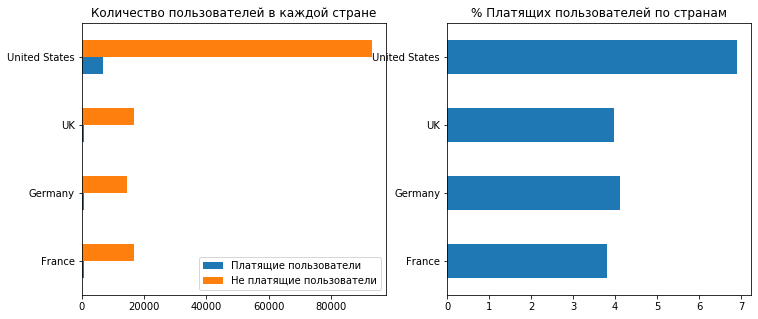

In [31]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
regions_table.plot(kind='barh', y=['Платящие пользователи','Не платящие пользователи'],ax=ax1)
ax2 = plt.subplot(1,2,2)

regions_table.plot(kind='barh',y='% платящих пользователей',ax=ax2, legend=False)

ax1.set_title('Количество пользователей в каждой стране')
ax1.set_ylabel('')
ax2.set_title('% Платящих пользователей по странам')
ax2.set_ylabel('')
plt.show()

По таблице мы видим, что в Америке самая большая доля платежеспособных клиентов. 6,9% от всех Американских пользователей делали покупки в приложении Procrastinate Pro+, у Германии, Франции и Соединенного Королевства доля платящих пользователей значительно ниже, самая низкая доля платящих пользователей во Франции - 3,8%.
В количественном выражении США также на первом месте, количество как платящих, так и неплатящих пользователей в несколько раз превосходит количество пользователей в других странах.

Рассмотрим, с каких девайсов заходит больше платящих пользователей, а также в целом рассмотрим какими устройствами пользуются клиенты приложения Procrastinate Pro+.

In [32]:
# сведение таблицы по используемым устройствам

device_used = profiles.pivot_table(
    index='device', values=['user_id', 'payer'], aggfunc={'user_id':'nunique', 'payer':'sum'})
device_used['% Платящих'] = round(device_used['payer'] / device_used['user_id'] * 100, 2)
device_used = device_used.rename(columns={'user_id':'Количество пользователей', 'payer':'Количество платящих пользователей'})
device_used['Количество платящих пользователей'] = device_used['Количество платящих пользователей'].astype(int)
device_used.sort_values(by='Количество пользователей', ascending=False)

,Количество платящих пользователей,Количество пользователей,% Платящих
device,,,
iPhone,3382,54479,6.21
Android,2050,35032,5.85
PC,1537,30455,5.05
Mac,1912,30042,6.36


По таблице делаем вывод, что наибольшее количество новых пользователей в исследуемый период использует приложение с iPhone, количество пользователей, зашедших с "яблочных" мобильных устройств в полтора раза выше, чем с мобильных устройств Android, которые находятся на 2 месте с количеством уникальных пользователей 35 тысяч человек.

Cамый высокий процент платящих среди пользователей Mac - 6,36% от общего числа пользователей данного типа устройств, на втором месте пользователи iPhone - 6,21%.

Наименьший процент платящих пользователей принадлежит пользователям, заходившим с PC - 5,05%, при этом общее количество пользователей Mac и PC примерно одинаковое: 30042 и 30455 пользователей соответственно.

Рассмотрим профили пользователей по каналам привлечения, чтобы ответить на последний поставленный в данном пункте вопрос: 

"По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?"

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платных пользователей.

In [33]:
# сведение таблицы по каналам привлечения

channels_used = profiles.pivot_table(
    index='channel', values=['user_id', 'payer'], aggfunc={'user_id':'nunique', 'payer':'sum'})
channels_used['% платящих'] = round(channels_used['payer'] / channels_used['user_id'] * 100,2)
channels_used = channels_used.rename(columns={'payer': 'Платящие пользователи', 'user_id': 'Количество пользователей'})
channels_used['Платящие пользователи'] = channels_used['Платящие пользователи'].astype(int)
channels_used.sort_values(by='% платящих', ascending=False)

,Платящие пользователи,Количество пользователей,% платящих
channel,,,
FaceBoom,3557,29144,12.20
AdNonSense,440,3880,11.34
lambdaMediaAds,225,2149,10.47
TipTop,1878,19561,9.60
RocketSuperAds,352,4448,7.91
WahooNetBanner,453,8553,5.30
YRabbit,165,4312,3.83
MediaTornado,156,4364,3.57
LeapBob,262,8553,3.06


Всего 11 каналов привлечения, больше всего платящих пользователей пришло в приложение через FaceBoom - 12,2%. На втором месте AdNonSense c % платящих равном 11,34.

Топ 5 каналов по доле платящих пользователей выглядит следующим образом:
1. FaceBoom - 12,2%
2. AdNonSense - 11.34%
3. lambdaMediaAds - 10.47%
4. TipTop - 9.6%
5. RocketSuperAds - 7.91%

При этом, самый низкий процент пользователей, перешедших из неплатящих в платящих по органическому трафику, всего 2,06%.

В количественном выражении больше всего пользователей пришло по органическому трафику, на втором месте FaceBoom, на третьем - TipTop.

**Вывод**

При рассмотрении профилей пользователей была получена следующая информация:
- в период с 01.05.2019 по 27.10.2019 в приложение Procrastinate Pro+ пришли пользователи из 4 стран: США, Соединенное Королевство, Германия, Франция;
- наибольшее число платящих пользователей из США - их 77,72% от общего числа платящих пользователей, равному 8881, наименьший процент платящих из Германии - 6,94%. Из Франции и UK немногим выше - 7,47% и 7,88% соответственно;
- доля платящих пользователей больше всего в США - 6,9% от общего числа пользователей из Америки, самая низкая во Франции - 3,8%;
- пользователи заходили в приложение из 4 типов устройств: iPhone, Android, Mac, PC. Самая большая доля пользователей - владельцы iPhone их 54 479 человек от общего числа в 150 тысяч пользователей, на втором месте владельцы Android - 35 032 человек. Пользователи Mac и PC практически равны друг другу с количеством в 30 тысяч человек;
- наибольшая доля платящих пользователей - это владельцы Mac - их 6,36% от общего числа пользователей Mac, наименьшая - PC с долей 5,05%;
- топ 5 каналов привлечения по доле привлеченных платных пользователей: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds. По количеству привлеченных пользователей больше всего пришло напрямую по каналу organic, на 2 месте FaceBoom, на 3 - TipTop. Самый маленький процент платящих пользователей перешел с канала OppleCreativeMedia - 2,71% от общего числа пользователей по данному каналу привлечения.

## Анализ затрат на маркетинг

В данном пункте рассмотрим затраты на привлечение пользователей и ответим на следующие вопросы:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника

In [34]:
# получение расходов по источникам и по месяцам

acquisition_costs = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')
print('Общие расходы на привлечение пользователей в период 01.05.2019 - 27.10.2019 в приложение Procrastinate Pro+: {}'.format(round(acquisition_costs['acquisition_cost'].sum(), 2)))

Общие расходы на привлечение пользователей в период 01.05.2019 - 27.10.2019 в приложение Procrastinate Pro+: 105497.3


Общие расходы на маркетинг составили 105 497,30 у.е., посмотрим в таблице, как траты разделились по источникам

In [35]:
acquisition_costs.sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего денежных средств было вложено в TipTop, чуть менее 50% от общих издержек, на 2 месте FaceBoom, в данный канал была потрачена почти треть израсходованного бюджета, на остальные каналы потрачено значительно меньше, от 944,22 у.е. до 5151 у.е.

Изучим на графике, как траты распределены по источникам во времени

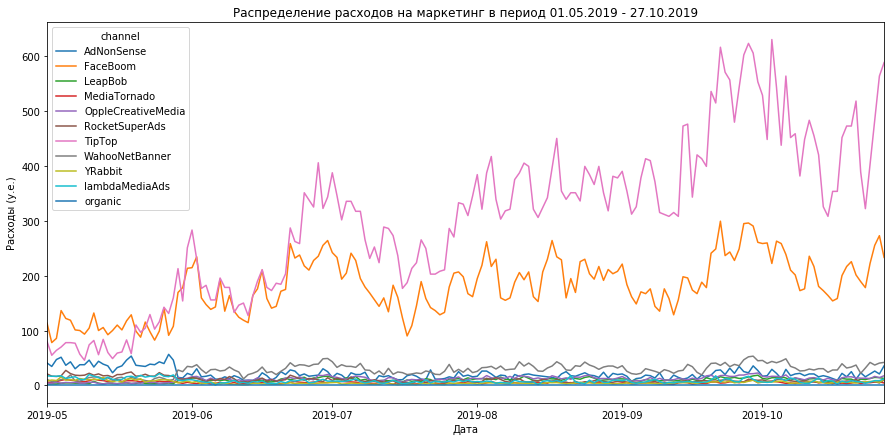

In [36]:
ac_in_time = profiles.pivot_table(index='dt', columns = 'channel', values='acquisition_cost', aggfunc='sum')
ac_in_time.plot(figsize=(15,7))
plt.title('Распределение расходов на маркетинг в период 01.05.2019 - 27.10.2019')
plt.xlabel('Дата')
plt.ylabel('Расходы (у.е.)')
plt.show()

На представленном графике выделяются два источника с наибольшими расходами - TipTop и FaceBoom, причем пиковые значения расходов наблюдаются в конце сентября и начале октября 2019 года.

На другие источники сумма расходов была значительно ниже и они не достигают отметки в 100 единиц на протяжении всего рассматриваемого временного промежутка в день. Посмотрим на график с применением скользящего среднего для сглаживания.

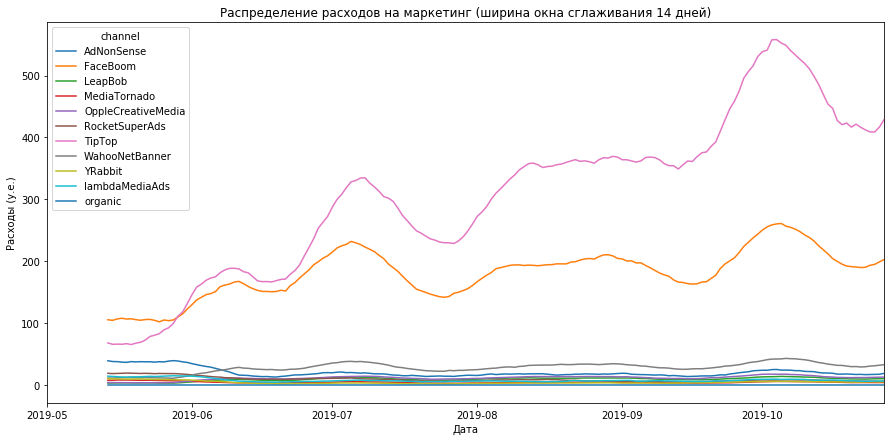

In [37]:
ac_copy = ac_in_time
for column in ac_copy.columns.values:
    ac_copy[column] = ac_copy[column].rolling(14).mean()
ac_copy.plot(figsize=(15,7))
plt.title('Распределение расходов на маркетинг (ширина окна сглаживания 14 дней)')
plt.xlabel('Дата')
plt.ylabel('Расходы (у.е.)')
plt.show()

По менее шумному графику можно сделать вывод, что расходы на маркетинг по каналам FaceBoom и TipTop имеют тенденцию к росту на протяжении всего рассматриваемого периода, а остальные каналы идут ровно, практически без изменений в отметке от 0 до 40 условных единиц.

В профилях пользователей расчитаны затраты на привлечение каждого клиента, рассмотрим средние затраты на одного клиента по источникам привлечения на основе этих данных.

In [38]:
# средние затраты на привлечение одного пользователя без разделения на источники
print('Средняя стоимость привлечения пользователя: {}'.format(round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)))

Средняя стоимость привлечения пользователя: 1.13


In [39]:
avg_ac_per_channel = profiles.query('channel != "organic"').pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
avg_ac_per_channel.sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


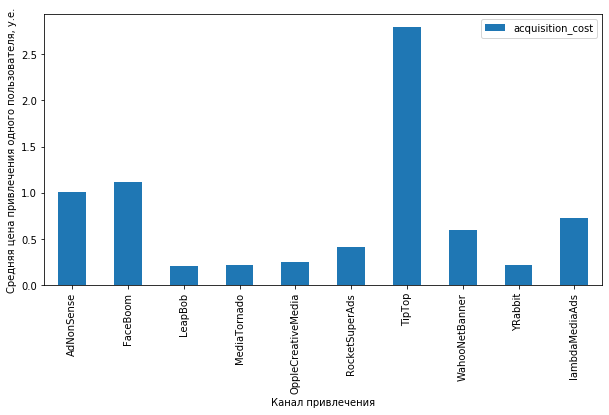

In [40]:
# визуализация средней стоимости клиента по каналам

avg_ac_per_channel.plot(kind='bar', figsize=(10,5))
plt.xlabel('Канал привлечения')
plt.ylabel('Средняя цена привлечения одного пользователя, у.е.')
plt.show()

Пользователи, привлеченные по каналу TipTop, являются в среднем самыми дорогими. Средняя стоимость привлечения пользователя равна 2,8 у.е., на 2 и 3 месте пользователи привлеченные каналами FaceBoom и AdNonSense - 1,11 и 1,01.

**Вывод**

Рассмотрев затраты на маркетинг мы сделали следующие выводы:

- общие расходы на маркетинг за пол года (привлечение пользователей в приложение Procrastinate Pro+ через платные каналы привлечениЯ) составили 105 497,30 условных единиц (предположительно стоимость указана в долларах);
- больше всего денежных средств маркетологи вложили в канал привлечения TipTop - почти половина всего бюджета. В FaceBoom - почти одна треть. Продвижение через остальные каналы имело расходы значительно ниже;
- ежедневные расходы на каналы привлечения TipTop и Faceboom имеют тенденцию к росту на протяжении всего рассматриваемого периода;
- средняя стоимость привлечения одного пользователя равна 1,13 у.е., однако при разделении стоимости пользователей в разрезе каналов привлечения, выявлено, что один пользователь, пришедший через TipTop обошелся в 2,8 у.е., что значительно превышает стоимость привлечения из других каналов. На втором месте FaceBoom со стоимостью 1,11;
- cамые "дешевые" пользователи с каналов YRabbit, MediaTornado, LeapBob.

## Оценка окупаемости рекламы для привлечения пользователей

В данном пункте с помощью расчета LTV и ROI выполним следующее:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Выявим проблемы и ответим на следующие вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

### Анализ общей окупаемости рекламы

Расчитаем по функциям в пункте 2 исследования окупаемость рекламы без учета дополнительных факторов. За окупаемость отвечают показатели LTV и ROI

Для начала определим момент и горизонт анализа, данные рассматриваются на дату 01.11.2019, принято считать, что для пользователей Procrastinate Pro+ окупаемость наступает не позднее 2 недель после появления нового пользователя.

In [41]:
# установка горизонта и момента анализа

horizon_days = 14 # так как окупаемость наступает за 2 недели (горизонт анализа)
observation_date = datetime(2019,11,1).date() # момент анализа
profiles = profiles.query('channel != "organic"')

In [42]:
# расчет LTV ROI и CAC

result_raw, ltv, ltv_in_time, roi, roi_in_time = get_ltv_roi(profiles, orders, observation_date, horizon_days)

In [43]:
# таблица LTV
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All,88644,0.34558,0.435754,0.504507,0.56109,0.611436,0.654368,0.69414,0.729778,0.764619,0.796665,0.826152,0.85207,0.878116,0.90203


Пожизненная ценность новых пользователей Procrastinate Pro+ за 2 недели достигла показателя в 0,68 у.е. на пользователя, чтобы понять, насколько пользователи "качественные", необходимо определить стоимость привлечения пользователей и возврат инвестиций.

In [44]:
# таблица roi
roi

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,,
All,88644,1.117794,0.309163,0.389834,0.451341,0.501962,0.547002,0.58541,0.620991,0.652873,0.684043,0.712711,0.739091,0.762278,0.785579,0.806974


Уже по показателю CAC мы видим, что он превышает накопленную за 2 недели пожизненную ценность клиентов, так как равен 0,695. Соответственно и ROI меньше единицы. 

Построим графики, установим окно сглаживания 7 дней, чтобы видеть меньше помех на динамике графиков.

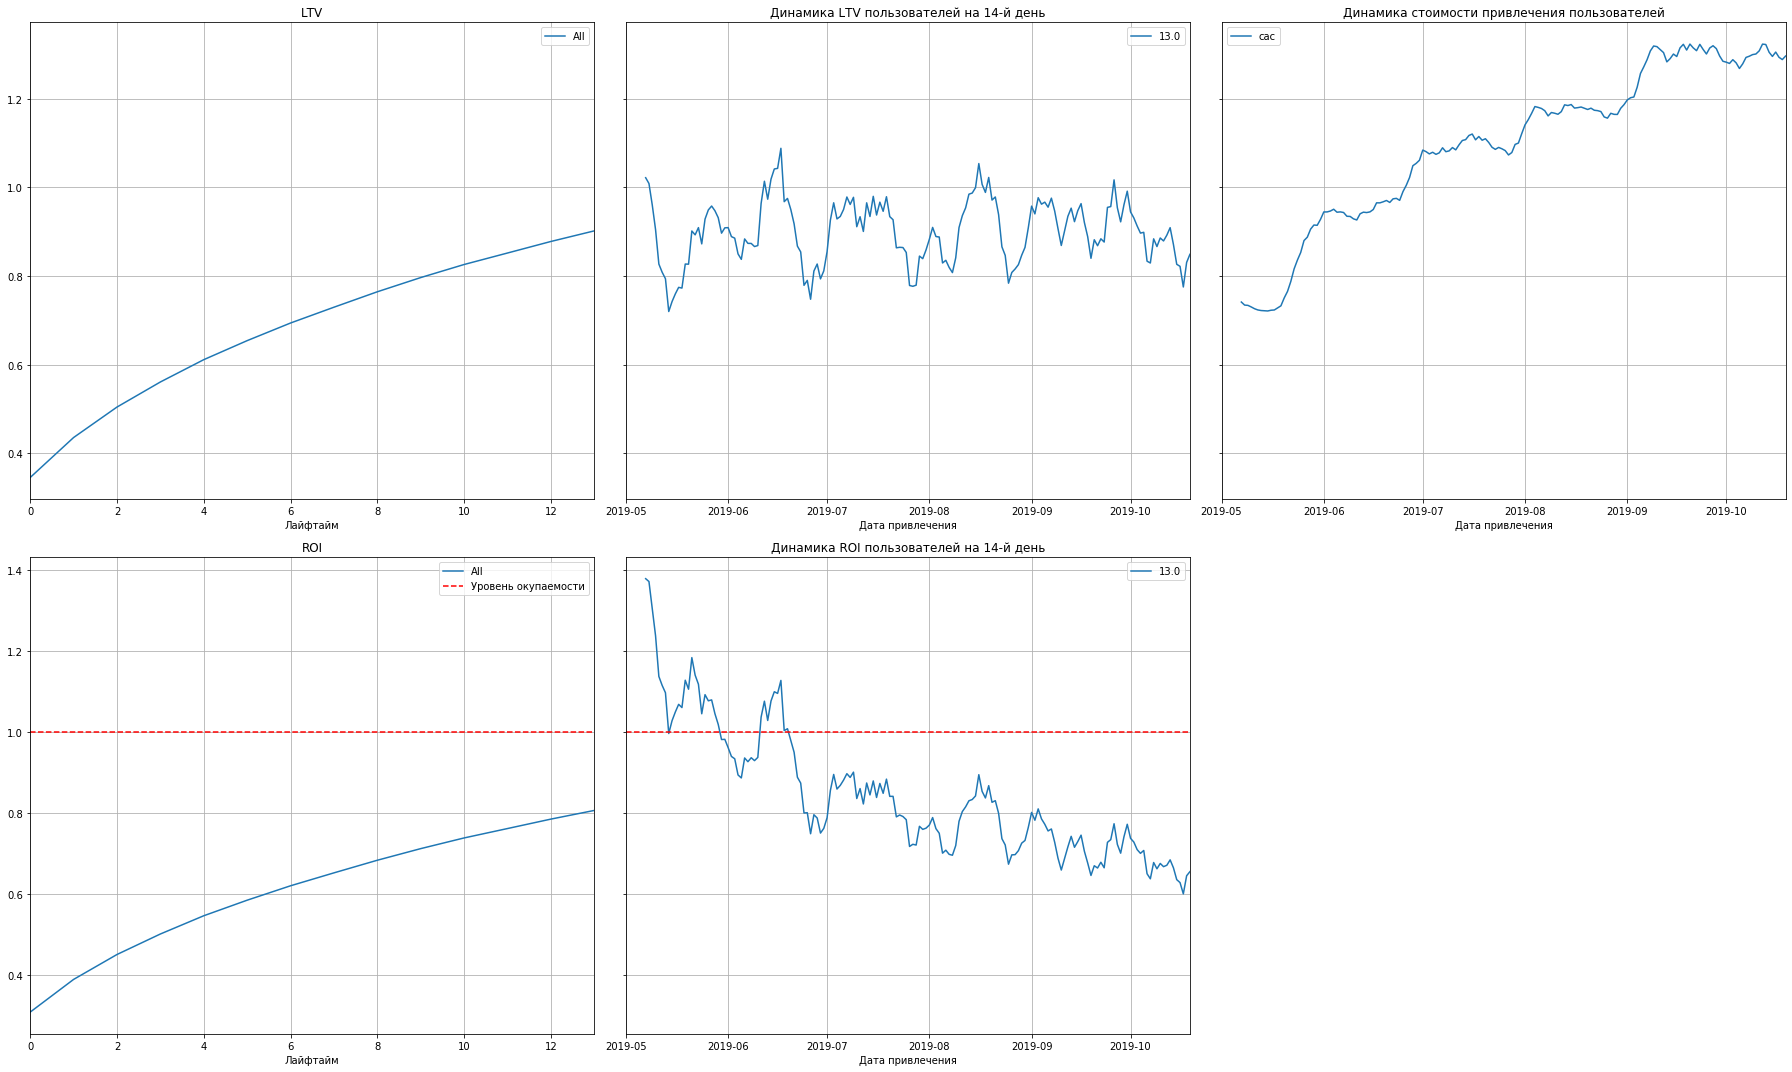

In [45]:
plot_ltv_roi(ltv, ltv_in_time, roi, roi_in_time, 14, window=7)

По графикам можно сделать следующие выводы:

- по графику динамики стоимости привлечения пользователей (CAC) мы видим постоянный рост стоимости привлечения, в начале периода стоимость была на уровне 0,7 у.е. и к концу первого месяца выросла до 0,9. Далее идет постоянный рост до отметки 1,3 в ноябре месяце;
- инвестиции на маркетинг не окупаются на протяжении всего лайфтайма, график LTV имеет плавный рост до показателя 0,9 у.е., ROI не доходит до уровня окупаемости и находится значительно ниже единицы даже на 14 день жизни пользователя, с наивысшей отметкой 0,8;
- динамика LTV пользователей во времени скачущая, в целом, особо выраженного пика нет, LTV находится в промежутке от 0,8 до единицы на протяжении всего рассматриваемого периода;
- динамика ROI имеет отрицательную тенденцию и снижается на протяжении всего рассматриваемого периода, так как стоимость привлечения растет, а LTV находится примерно на одном уровне на протяжении полугода. В начале периода расходы на рекламу были меньше, поэтому реклама окупалась, под конец мая идет спад ROI, затем рост в середине июня выше уровня окупаемости и затем опять резкий спад и постоянное убывание графика, в ноябре показатель ROI имеет минимальное значение на отметке 0,6.

Рассмотрим общие коэффициенты удержания и конверсии

In [46]:
# расчет RR

rr_raw, retention, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days)

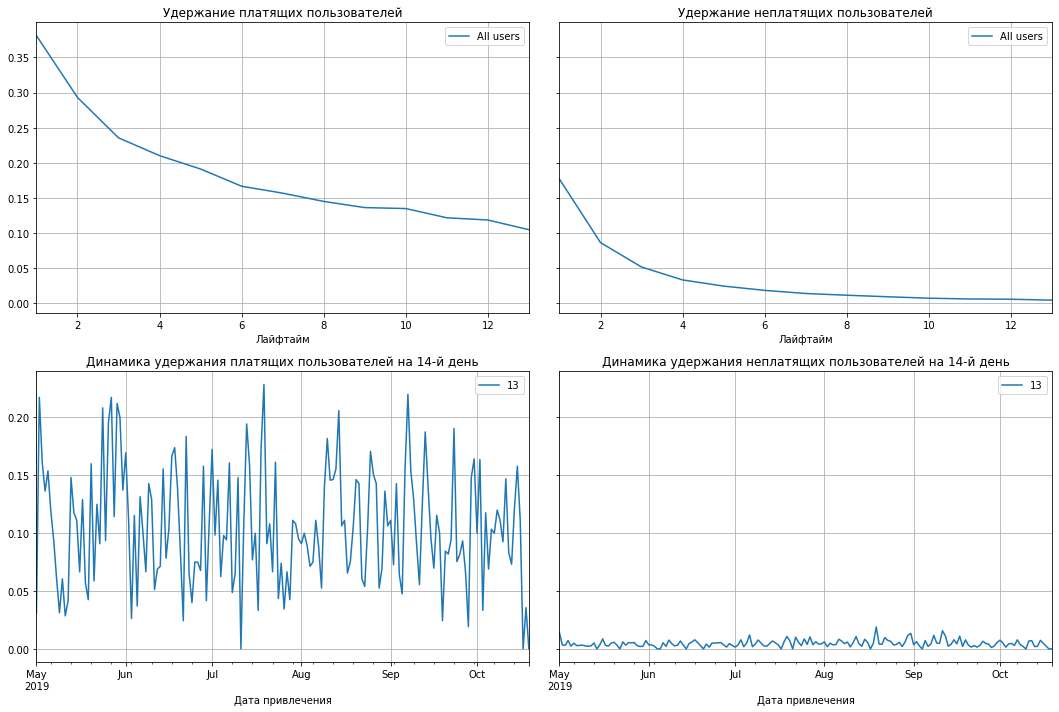

In [47]:
# визуализация удержания

plot_retention(retention, retention_in_time, 14, window=1)

По графикам видим, удержание платящих пользователей выше, что логично. Неплатящие пользователи практически не удерживаются, мы видим, как уже после 8 лайфтайма график близок к нулевому значению. В целом, коэффициент удержания имеет достаточно низкие показатели.

По динамике удержания мы также видим, что неплатящие пользователи на протяжении всего рассматриваемого периода на 14 день не удерживаются. Удержание платящих пользователей не превышает значения 0,25 на протяжении всего рассматриваемого периода.

Рассмотрим конверсию пользователей.

In [48]:
# расчет конверсии

conversion_raw, conversion, conversion_in_time = get_conversion(profiles, orders, observation_date, horizon_days)

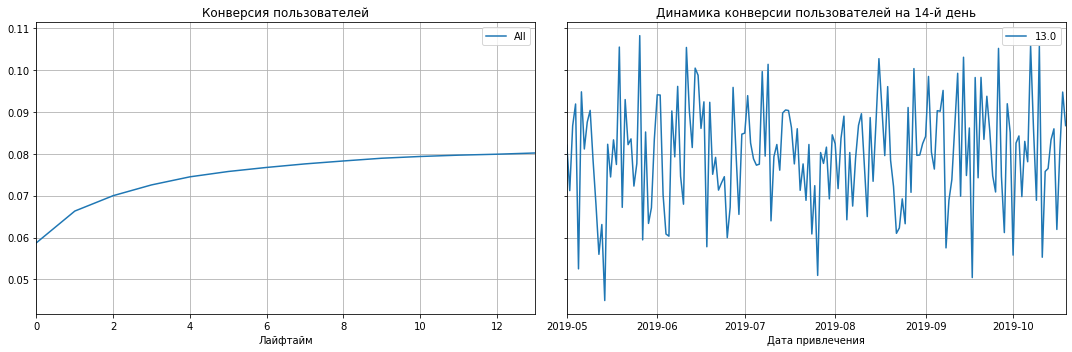

In [49]:
# визуализация конверсии

plot_conversion(conversion, conversion_in_time, 14, window=1)

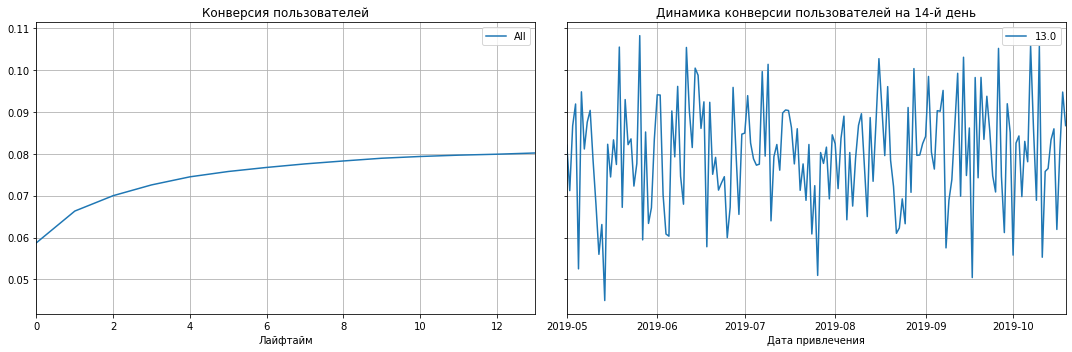

In [50]:
# Для примера посмотри на график конверсии без канала organic.
conversion_raw, conversion, conversion_in_time = get_conversion(profiles.query('channel != "organic"'), orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_in_time, 14, window=1)

Судя по графику конверсии, уверенный рост заметен с 1 по 3 день жизни пользователя, а далее конверсия растет с низкими темпами и уже на 8 день жизни пользователи конвертируются плохо. Показатель общей конверсии пользователей низкий, он не достигает даже 6% за 2 недели.

По динамике конверсии можно сказать, что на протяжении всего периода конвертируемость пользователей в платящих довольно низкая, и соотнося расходы на рекламу и небольшой рост конверсии в июне месяце можно уверенно говорить о низкой эффективности расходования рекламного бюджета, так как динамика конверсии не имеет тенденции к росту.

Помимо указанных выше выводов, мы можем ответить на вопрос "Окупается ли реклама, направленная на привлечение пользователей в целом?" - ответ нет, не окупается

Рассмотрим окупаемость, пожизненную ценность и показатели конверсии и удержания с разбивкой по различным факторам в профилях пользователей.

### Анализ окупаемости рекламы с разбивкой по устройствам

Добавим в качестве исследуемого фактора для разделения пользователей разбивку по типу устройств, из исследования мы выявили, что пользователи заходят в приложение с 4 типов устройств: iPhone, Android, PC, Mac.

Также расчитаем по функции LTV, ROI, CAC и динамику показателей.

In [51]:
# расчет LTV, CAC, ROI с разбивкой по устройствам

result_raw_devices, ltv_devices, ltv_in_time_devices, roi_devices, roi_in_time_devices = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

И построим графики для интерпретации показателей, также используем метод скользящего среднего, чтобы убрать шумы на графиках.

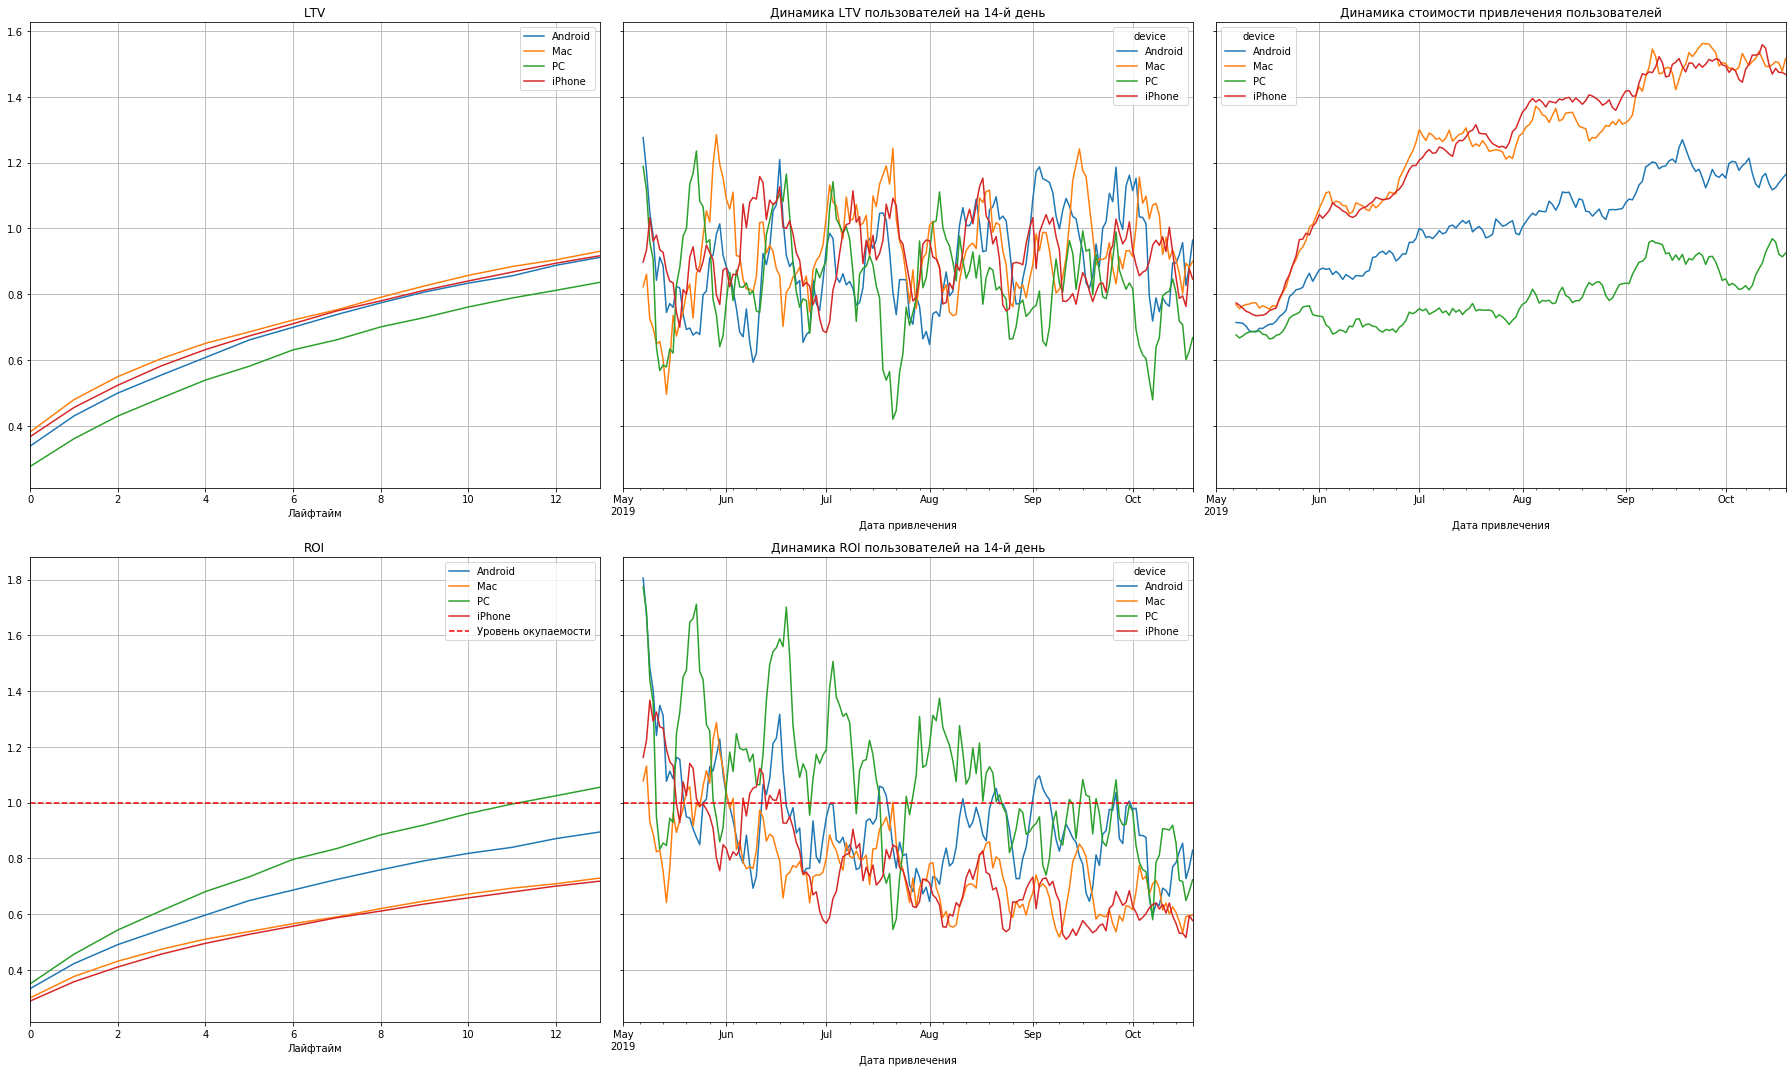

In [52]:
# визуализация показателей

plot_ltv_roi(ltv_devices, ltv_in_time_devices, roi_devices, roi_in_time_devices, 14, window=7)

При разделении пользователей по типам устройств, данные не сильно изменились. Мы видим, что LTV пользователей всех устройств, кроме PC находится примерно на одном уровне и к концу лайфтайма достигает в среднем 0,9 у.е.

Динамика LTV скачет аналогично общей динамике LTV и находится в промежутке между 0,4 до 1,3; Из графика динамики стоимости привлечения мы видим, что самая высокая стоимость привлечения у пользователей iPhone и Mac, самая низкая - PC.

К 14 дню лайфтайма окупаются пользователи PC, не окупаются пользователи всех остальных устройств.

При рассмотрении динамики ROI, мы также видим снижение показателя по датам привлечения, в начале рассматриваемого периода все пользователи были выше уровня окупаемости, а дальше, начиная с середины июня, только пользователи PC имеют периоды окупаемости с провалами, которые доходят до границы окупаемости к дате горизонта анализа.

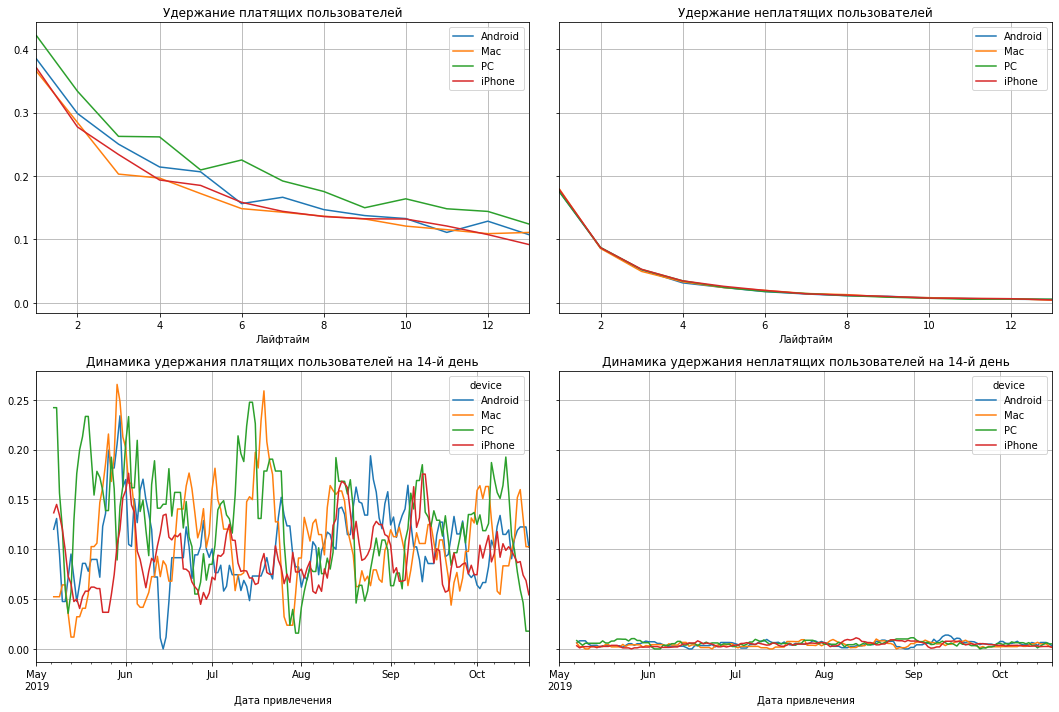

In [53]:
# расчет удержания пользователей по типам устройств и построение графиков

rr_devices_raw, rr_devices, rr_in_time_devices = get_retention(profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(rr_devices, rr_in_time_devices, 14, window=7)

Удержание стабильно низкое для пользователей всех типов устройств, немного выше удержание платящих пользователей PC, в остальном, по динамике удержания пиковый показатель у пользователей PC в середине мая.

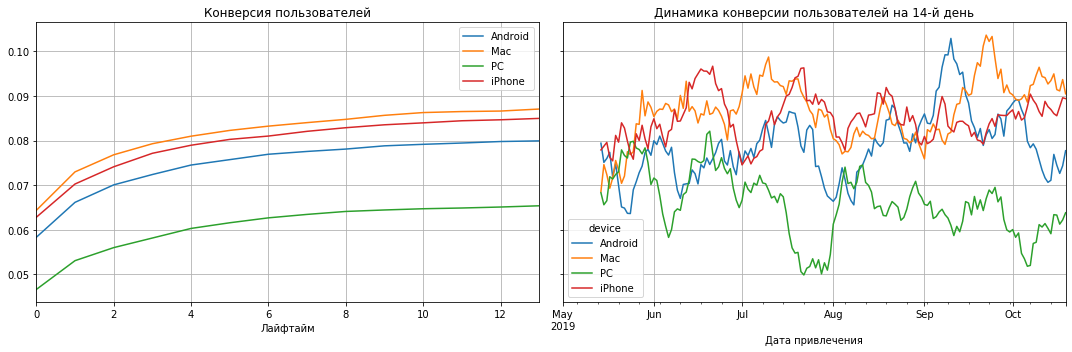

In [54]:
# расчет конверсии пользователей по типам устройств и построение графиков

conv_raw, conv_devices, conv_in_time_devices = get_conversion(profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conv_devices, conv_in_time_devices, 14, window=14)

Пользователи по всем устройствам стабильно конвертируются в платящих, у пользователей PC этот показатель еще ниже, чем у остальных.

Скорее всего проблема не в типах устройств, рассмотим показатели с разбивкой по другим факторам.

### Анали окупаемости рекламы с разбивкой по странам

В исследовании было выявлено, что пользователи приходят в приложение из 4 стран: США, Англия, Германия, Франция. Аналогично предыдущему пункту расчитаем показатели и рассмотрим графики.

In [55]:
# расчет LTV, CAC, ROI с разбивкой по странам

result_raw_region, ltv_region, ltv_in_time_region, roi_region, roi_in_time_region = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

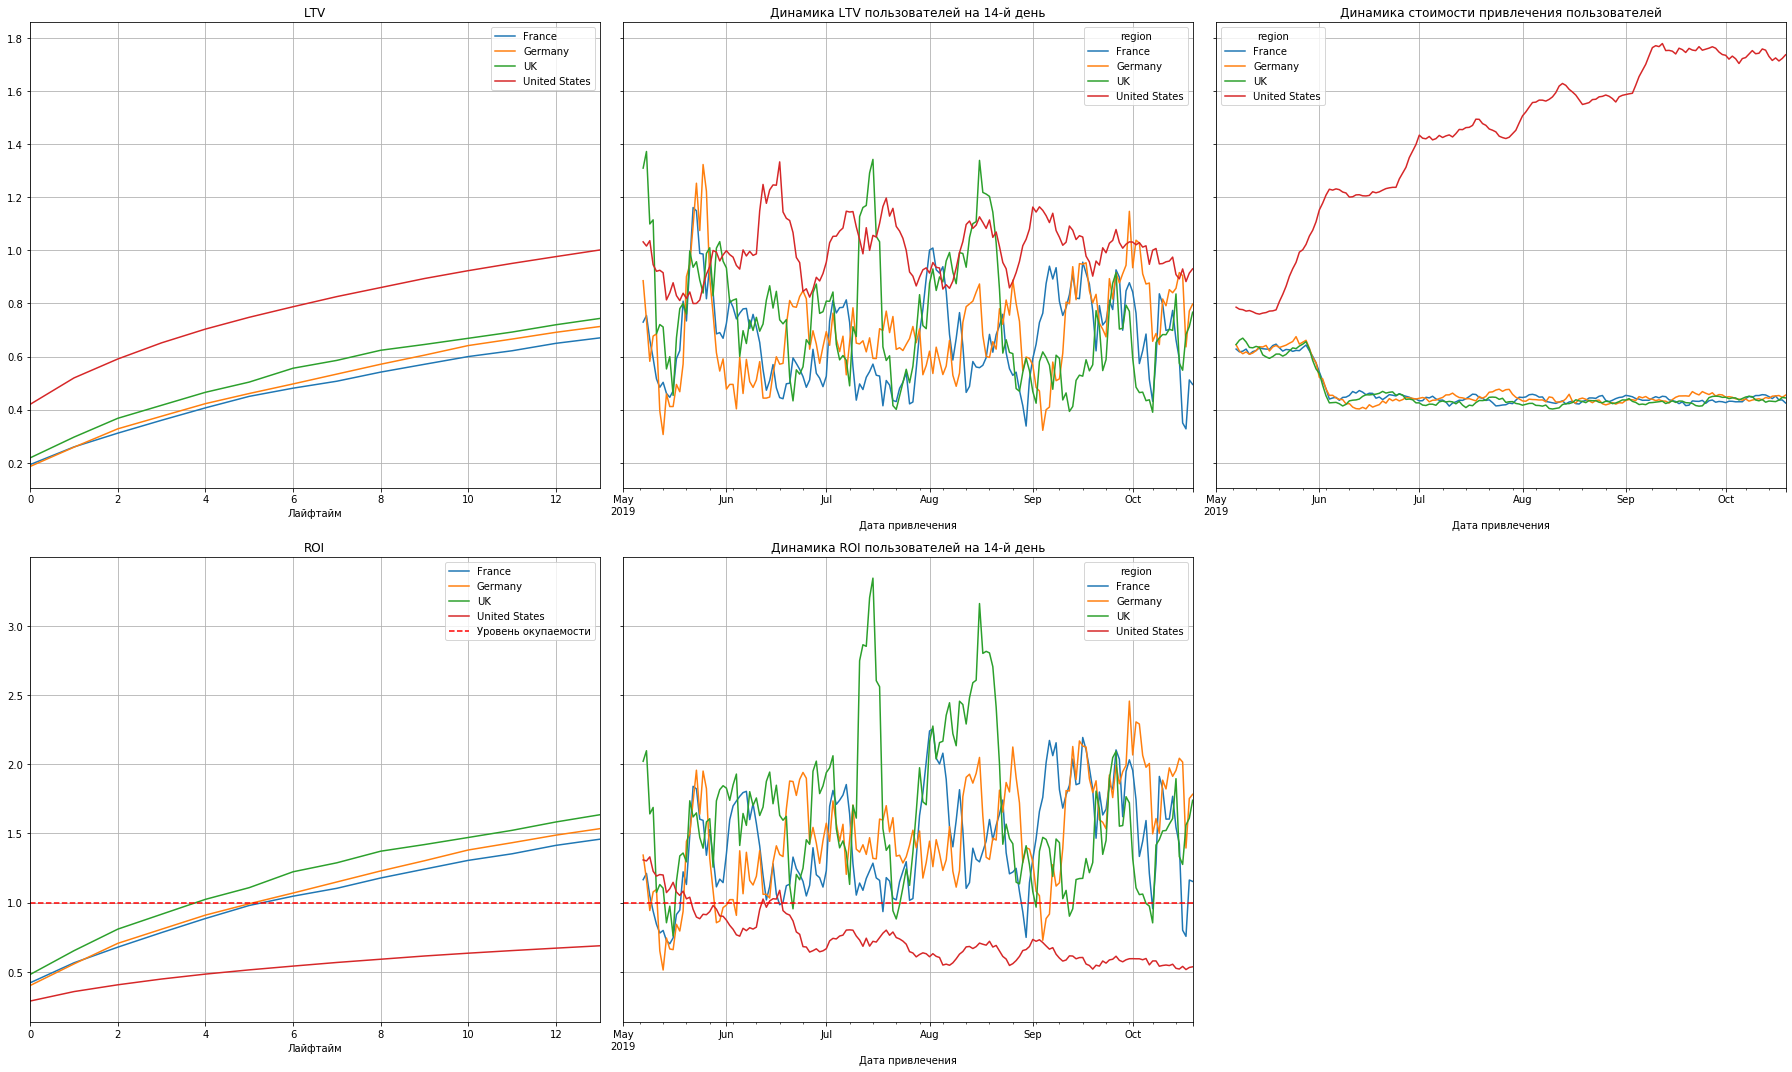

In [56]:
# визуализация показателей

plot_ltv_roi(ltv_region, ltv_in_time_region, roi_region, roi_in_time_region, 14, window=7)

По графикам можно сделать следующие выводы:

- LTV пользователей из Америки выше остальных, и к концу лайфтайма достигает 1,0 у.е., остальные страны примерно на одном уровне, немного ниже пользователи из Франции - 0,7 к 14 дню жизни.
- ROI пользователей из Франции, Германии и Соединенного королевства выше границы окупаемости, к 14 дню жизни пользователи окупаются в соотношении примерно 1,6, при этом Амреиканские пользователи не окупаются - к 14 дню жизни они не достигают отметки в 0,6
- из графика динамики стоимости привлечения мы видим, с чем связан рост цены привлечения на общем графике. Графики пользователей из Германии, Англии и Франции пологие и не имеют выраженной динамики роста, а стоимость привлечения пользователей из США в рассматриваемый период выраженно растет, начиная с середины мая и к ноябрю достигает стоимости близкой к 1,8 у.е.
- по графикам динамики ROI мы также видим, что окупаемость пользователей из Америки снижается и уже в мае граничит с порогом окупаемости, а дальше убывает до значения 0,5 в конце полугодия.



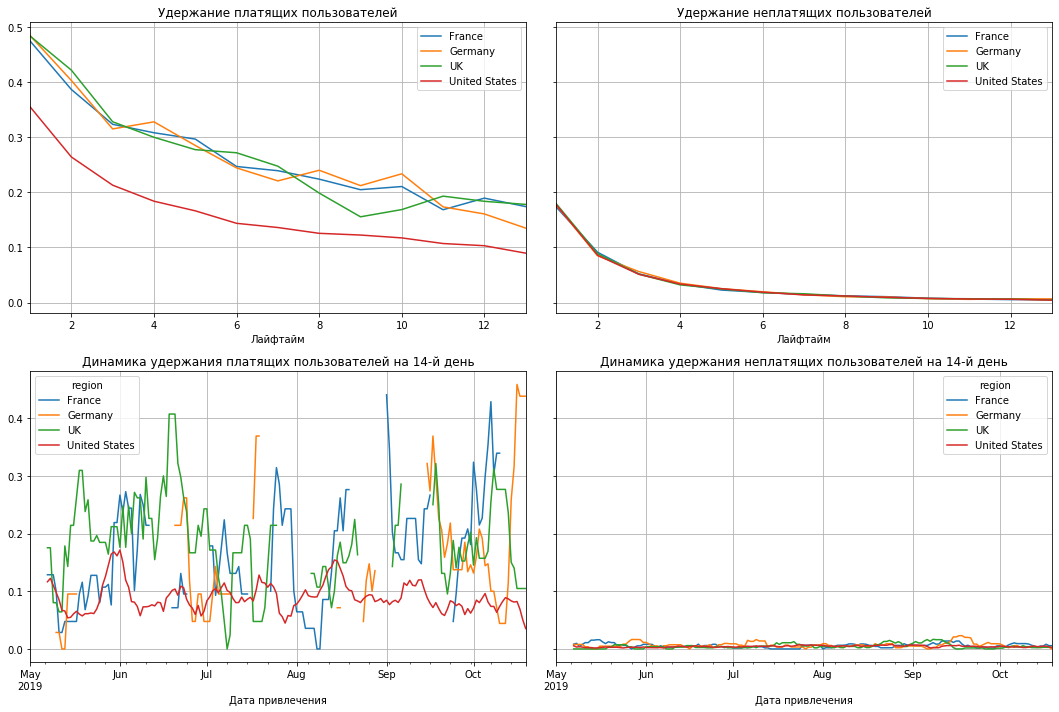

In [57]:
# расчет удержания пользователей по региону и построение графиков

rr_region_raw, rr_region, rr_in_time_region = get_retention(profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(rr_region, rr_in_time_region, 14, window=7)

Удержание неплатящих пользователей низкое и одинаковое для всех стран, по платящим пользователей видим, что удержание пользователей из США значительно ниже, чем в других странах, при этом из США самое большое количество пользователей.

По динамике удержания также видим, что по пользователям из США на протяжении всего полугода нету пиковых значений, которые есть, например, по пользователям из Франции и Германии.

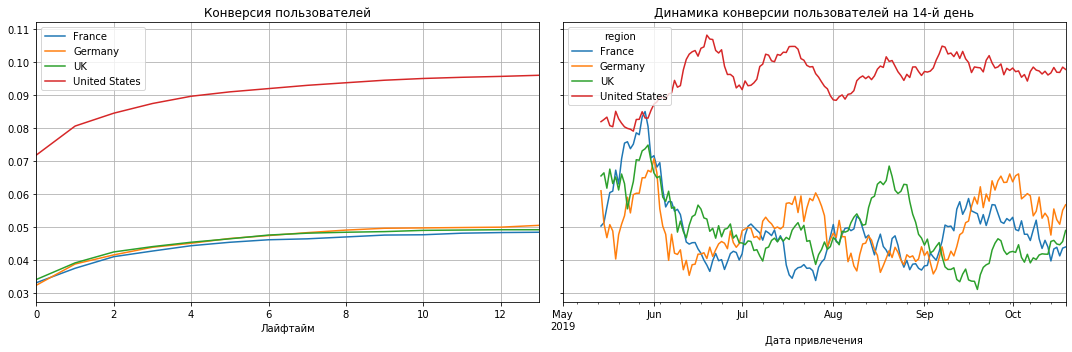

In [58]:
# расчет конверсии пользователей по регионам и построение графиков

conv_raw, conv_region, conv_in_time_region = get_conversion(profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_conversion(conv_region, conv_in_time_region, 14, window=14)

По конверсии мы видим, что пользователи из США, несмотря на низкие показатели удержания, конвертируются в платящих намного лучше других, более чем в 3  раза. По динамике конверсии также видим, что в июне наблюдается резкий рост конверсии пользователей из США.

Далее рассмотрим окупаемость рекламы и показатели конверсии и удержания по двум срезам: пользователи из США и пользователи из Европы, так как основная причина низкой окупаемости - это низкое качество пользователей из США, поэтому рассматривать их будем отдельно.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

Рассмотрим, как окупается реклама с разных каналов привлечения, перед этим уберем из профилей пользователей стран отличных от США и уберем пользователей, пришедших органически, то есть на которых не было потрачено средств в рекламные каналы

In [59]:
# создание среза профилей с пользователями из США и без органиков

profiles_usa = profiles.query('region == "United States" & channel != "organic"')

In [60]:
# расчет LTV, CAC, ROI с разбивкой по каналам привлечения

result_raw_channel, ltv_channel, ltv_in_time_channel, roi_channel, roi_in_time_channel = get_ltv_roi(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['channel']
)

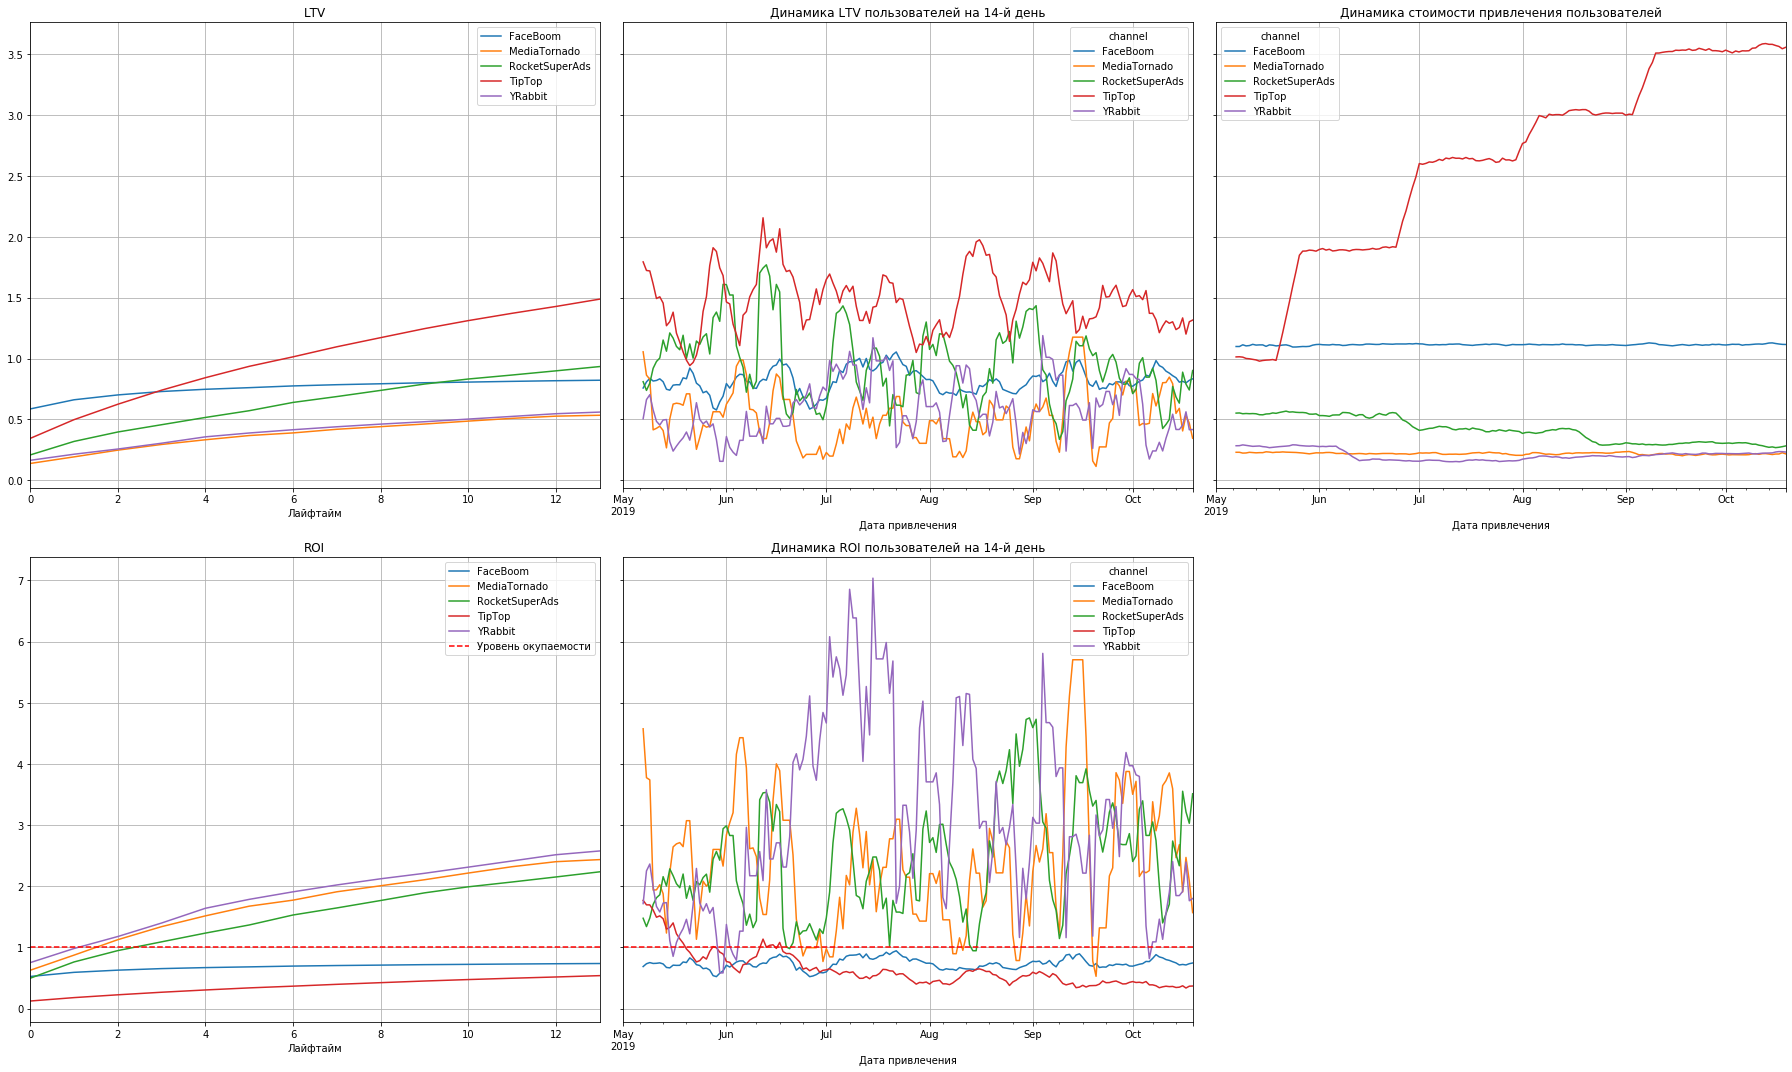

In [61]:
# визуализация показателей

plot_ltv_roi(ltv_channel, ltv_in_time_channel, roi_channel, roi_in_time_channel, 14, window=7)

Из анализа расходов на маркетинг мы выявили, что самые большие инвестиции были вложены в каналы продвижения TipTop и FaceBoom, на графиках указанные два канала также имеют наиболее выраженные тенденции.

- LTV пользователей с канала TipTop имеет самый высокий показатель, достигая к 14 лайфтайму значения 1,5 у.е., пользователи FaceBoom более пологие и с первого лайфтайма LTV практически не растет. LTV пользователей с канала RocketSuperAds к 14 лайфтайму становится выше, чем пользователей с канала FaceBoom;
- ROI пользователей с канала FaceBoom и TipTop самый низкий и не достигает порога окупаемости, при этом TipTop по данному показателю - самый не окупаемый канал со средним значением 0,5 к 14 лайфтайму, пользователи с остальных каналов окупаются и достаточно уверенно, к последнему лайфтайму окупаемость доходит до значений 2,4-2,6 у.е.
- по динамике LTV мы видим, что график пользователей с канала TipTop выше других графиков, но в целом находится достаточно близко к пользователям с канала RocketSuperAds, они имеют схожую резкость колебаний во времени;
- Динамика ROI в рассматриваемый горизонт анализа пользователей с каналов TipTop и FaceBoom выглядит удручающе, график не имеет роста и идет практически прямой линией ниже уровня окупаемости, что говорит об убыточности привлеченных с этих каналов пользователей на протяжении всего рассматриваемого периода, при этом если график FaceBoom не имеет тенденции к снижению и с мая по ноябрь находится примерно в промежутке 0,7-0,9, то график TipTop с течением времени снижается и средний ROI достигает отметки менее 0,5 к ноябрю;
- динамика стоимости привлечения отражает проблемы в затратах на маркетинг, Американские пользователи с канала привлечения FaceBoom обходятся компании дороже каналов YRabbit, RocketSuperAds и MediaTornado. Стоимость привлечения пользователей по каналу TipTop имеет тенденцию к резкому и постоянному росту с середины мая и достигает цены выше 3,5 у.е. за пользователя к концу рассматриваемого периода.



Рассмотрим пользователей из других стран, определив неэффективные каналы для них.

In [62]:
profiles_other = profiles.query('region != "United States" & channel != "organic"')

In [63]:
# расчет LTV, CAC, ROI с разбивкой по каналам привлечения

result_raw_channel, ltv_channel, ltv_in_time_channel, roi_channel, roi_in_time_channel = get_ltv_roi(
    profiles_other, orders, observation_date, horizon_days, dimensions=['channel']
)

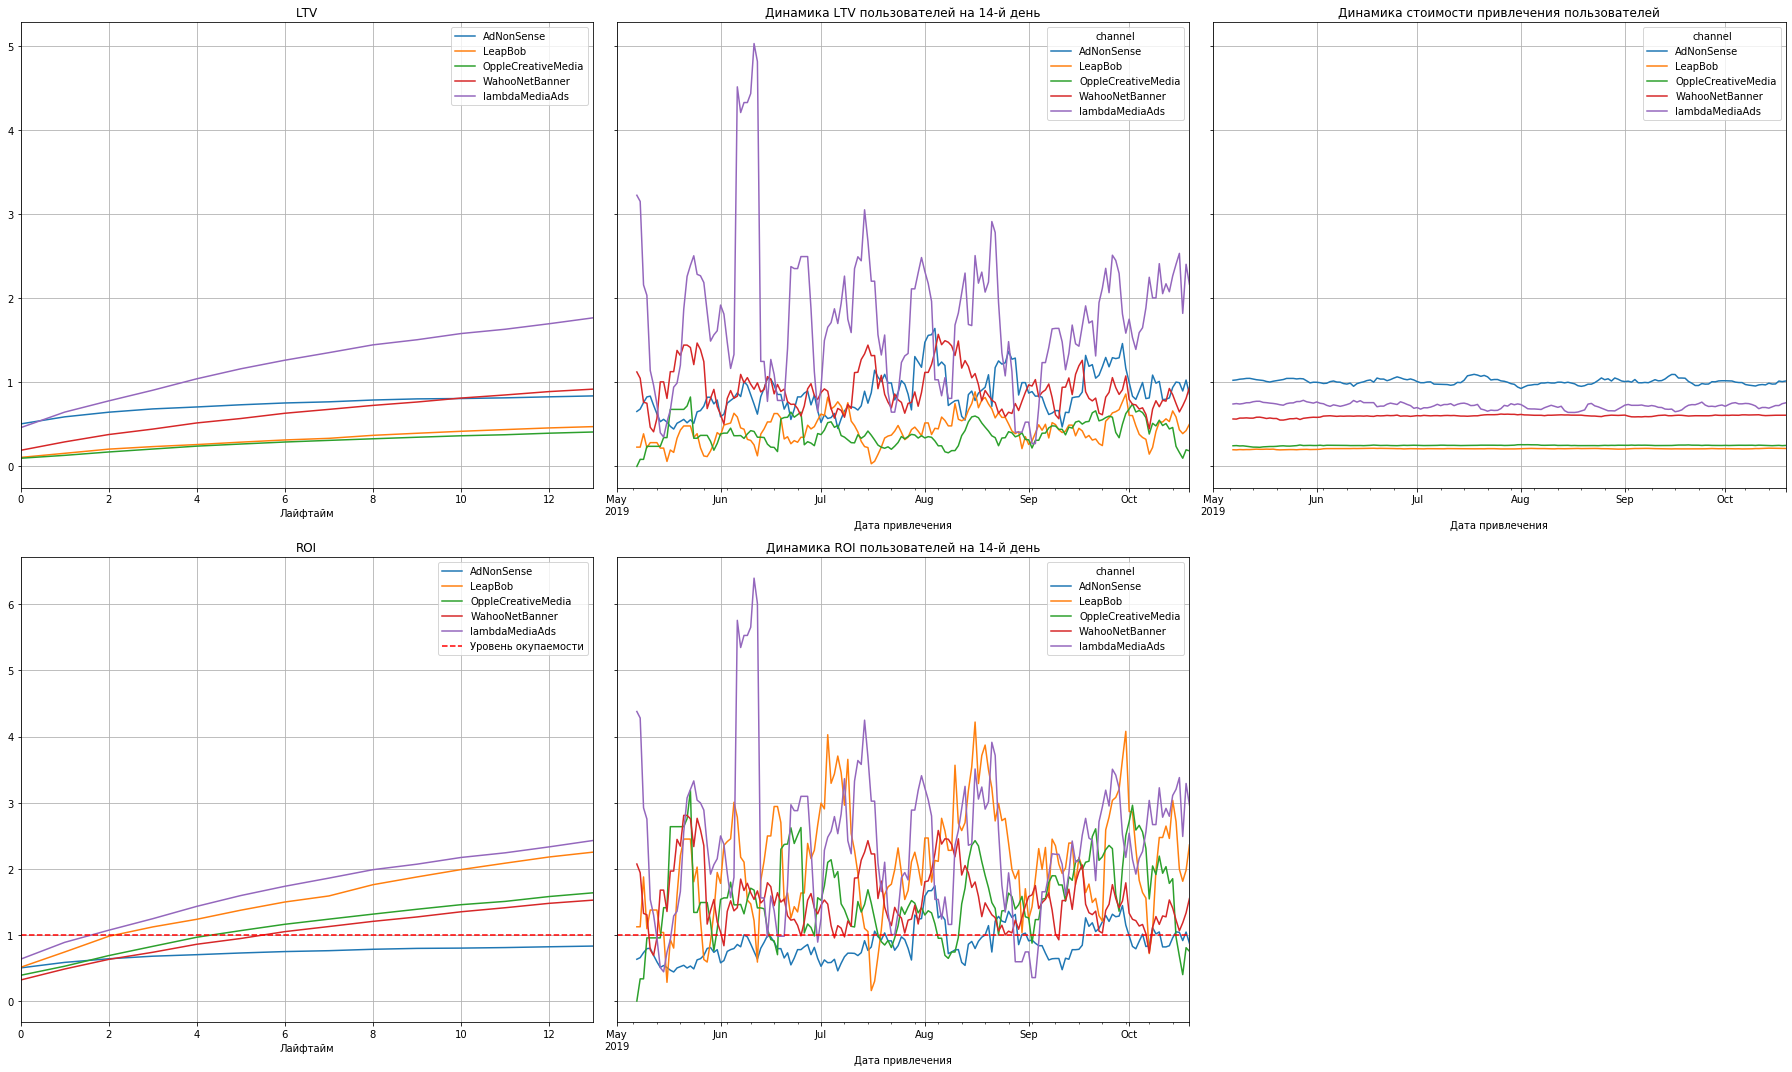

In [64]:
# визуализация показателей

plot_ltv_roi(ltv_channel, ltv_in_time_channel, roi_channel, roi_in_time_channel, 14, window=7)

Для пользователей из Германии, Англии и Франции по показателю ROI есть один неэффективный канал - AdNonSense - он не достигает порога окупаемости, остальные каналы на 5-7 день жизни пользователей окупаются.

По динамике мы также видим, что пользователи приходящие с канала AdNonSense не окупались на протяжении всего рассматриваемого периода, а в динамике стоимости привлечения пользователи с данного канала были самые дорогие также в течение всего полугода.

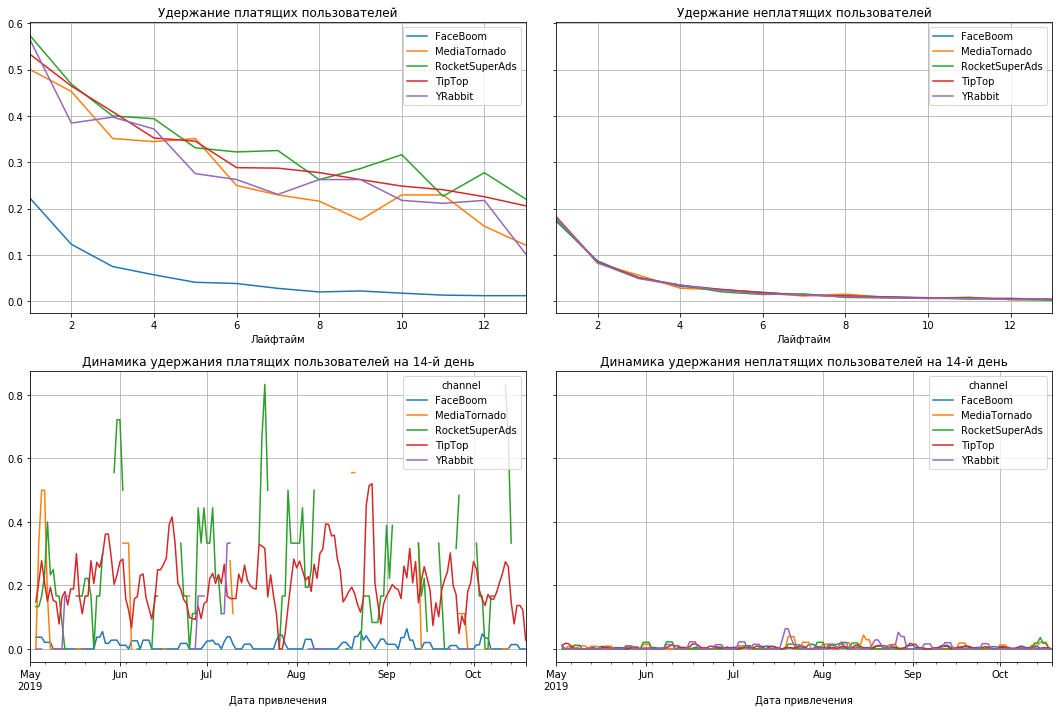

In [65]:
# расчет удержания пользователей по каналам привлечения и построение графиков (пользователи США)

rr_channel_raw, rr_channel, rr_in_time_channel = get_retention(profiles_usa, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(rr_channel, rr_in_time_channel, 14, window=3)

Удержание пользователей из США низкое по каналу привлечения FaceBoom, к концу второй недели удерживается практически нулевой процент пользователей из данного канала, так как мы не располагаем данными о событиях, будем считать, что пользователи привлекаемые по каналу FaceBoom не качественные, остальные Американские каналы привлечения показывают достаточно стабильные показатели удержания.

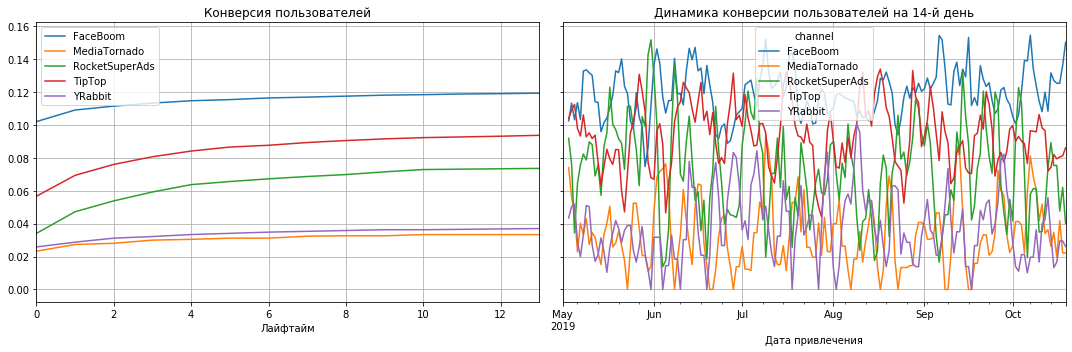

In [66]:
# расчет конверсии пользователей по каналам привлечения и построение графиков (пользователи США)

conv_raw, conv_channel, conv_in_time_channel = get_conversion(profiles_usa, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conv_channel, conv_in_time_channel, 14, window=3)

Конверсия пользователей США, пришедших из разных каналов, свидетельствует о том, что лучше всего конвертируются в платящих пользователи из FaceBoom, однако по удержанию мы выявили, что они редко задерживаются в приложении и в среднем уходят уже в конце первой недели. Самая низкая конверсия по каналам MediaTornado и YRabbit, однако полученные из этих каналов пользователи обходятся по стоимости ниже остальных и у них самые высокие показатели окупаемости рекламы. Возможно стоит вкладывать больше рекламного бюджета в данные каналы.

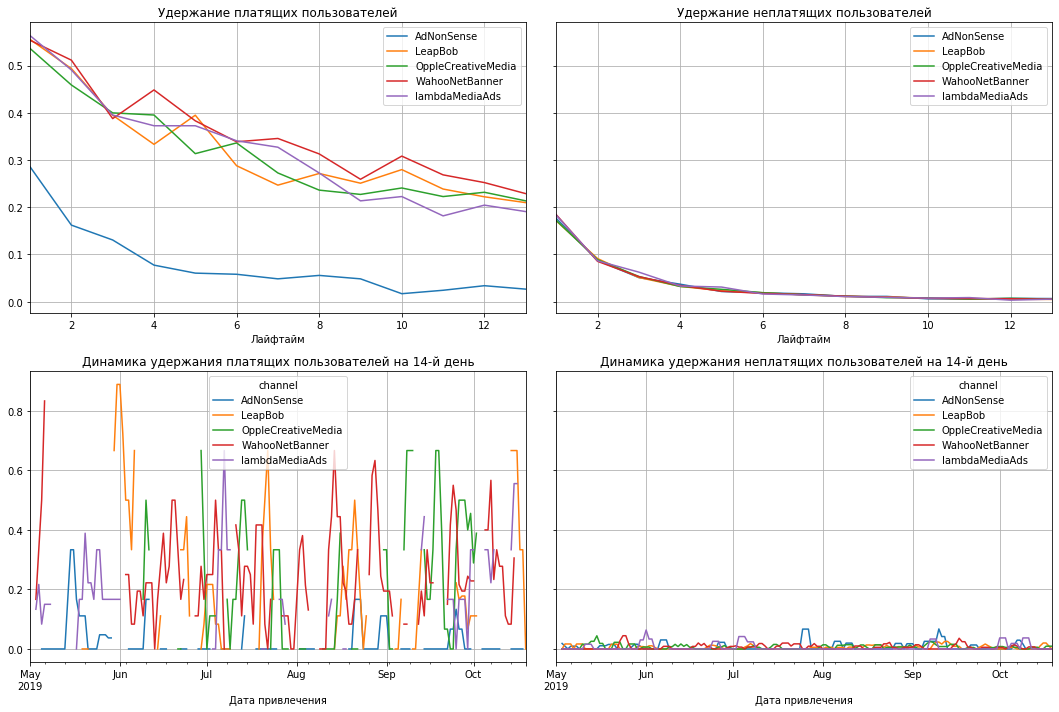

In [67]:
# расчет удержания пользователей по каналам привлечения и построение графиков (пользователи европы)

rr_channel_raw, rr_channel, rr_in_time_channel = get_retention(profiles_other, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(rr_channel, rr_in_time_channel, 14, window=3)

Среди Европейских каналов привлечения также есть очевидный аутсайдер по удержанию платящих пользователей - это пользователи пришедшие через рекламу в AdNonSense, их удержание и в начале лайфтайма низкое, и быстро снижается ниже показателя 10% - уже к середине-концу первой недели.

По динамике удержания также AdNoNSense не имеет особо выраженных пиков и находится на протяжении всего рассматриваемого периода ниже других каналов.

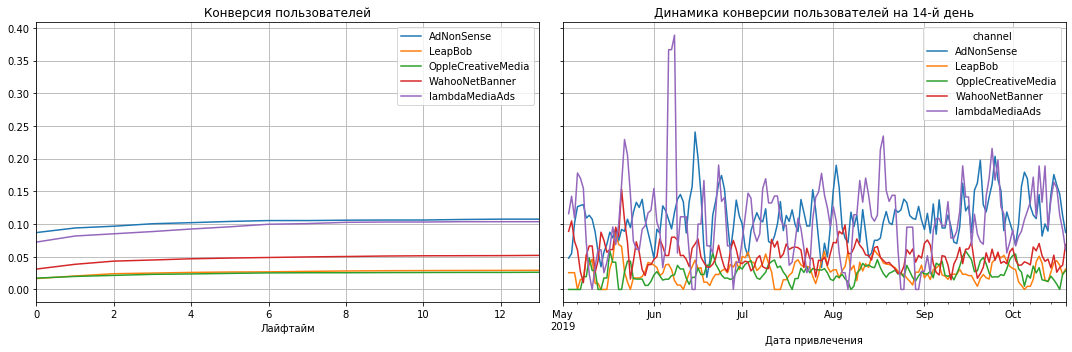

In [68]:
# расчет конверсии пользователей по каналам привлечения и построение графиков (пользователи европы)

conv_raw, conv_channel, conv_in_time_channel = get_conversion(profiles_other, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conv_channel, conv_in_time_channel, 14, window=3)

Несмотря на низкое удержание пользователей, конверсия пользователей по каналу AdNonSense одна из высоких. AdNonSense и lambdaMediaAds имеют конверсию в 2 раза выше, чем с других каналов привлечения, по динамике конверсии мы видим, что lambdaMediaAds находится на 1 месте.  LTV и ROI пользователей пришедших по каналу lambdaMediaAds самые высокие, среди всех европейских каналов, поэтому стоит рассмотреть указанный канал, как один из основных по привлечению европейских пользователей.

## Общие выводы

На основании проведенного исследования рекламной кампании для приложения Procrastinate Pro+, проводимой в период 01.05.2019 - 27.10.2019, мы сделали следующие выводы:

- большая часть привлеченных в указанный период пользователей Procrastinate Pro+ - это пользователи из США (более 77% от всех платящих пользователей);
- cамая большая доля пользователей - владельцы iPhone их 54 479 человек от общего числа в 150 тысяч пользователей, на втором месте владельцы Android - 35 032 человек. Пользователи Mac и PC практически равны друг другу с количеством в 30 тысяч человек;
- наибольшая доля платящих пользователей - это владельцы Mac - их 6,36% от общего числа пользователей Mac, наименьшая - PC с долей 5,05%;
- топ 5 каналов привлечения по доле привлеченных платных пользователей: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds. По количеству привлеченных пользователей больше всего пришло напрямую по каналу organic, на 2 месте FaceBoom, на 3 - TipTop. Самый маленький процент платящих пользователей перешел с канала OppleCreativeMedia - 2,71% от общего числа пользователей по данному каналу привлечения;
- больше всего денежных средств вложено в канал привлечения TipTop - почти половина всего бюджета. В FaceBoom - одна треть. Продвижение через остальные каналы имело расходы значительно ниже, при этом ежедневные расходы на каналы привлечения TipTop и Faceboom имеют тенденцию к росту на протяжении всего рассматриваемого периода;
- самые "дорогие" пользователи приходили через канал TipTop - их средняя стоимость 2,8 у.е, а также с FaceBoom - их стоимость 1,11 у.е., cамые "дешевые" пользователи с каналов YRabbit, MediaTornado, LeapBob.
- платящие пользователи плохо удерживаются, к концу 2 недели их удерживается менее 15%, рост конверсии после 3 дня жизни пользователей очень маленький и график конверсии практически пологий в отметке до 6% сконвертированных пользователей;
- несмотря на высокую конверсию и LTV пользователей из США, они не окупаются и окупаемость инвестиций по пользователям из США ниже границы окупаемости в динамике на протяжении всего рассматриваемого периода, при этом стоимость привлечения Американских пользователей в несколько раз выше пользователей из Европы;
- удержание пользователей из США ниже, чем пользователей из Европы;
- самые большие рекламные инвестиции были вложены в каналы продвижения TipTop и FaceBoom, при этом ROI пользователей с канала FaceBoom и TipTop самый низкий и не достигает порога окупаемости, при этом TipTop по данному показателю - самый не окупаемый канал со средним значением 0,5 к 14 лайфтайму, пользователи с остальных каналов окупаются и достаточно уверенно, к последнему лайфтайму окупаемость доходит до значений 2,4-2,6 у.е.; удержание пользователей из США самое низкое по каналу привлечения FaceBoom, несмотря на высокую конверсию пользователей из данного канала привлечения;
- Американские каналы привлечения MediaTornado, YRabbit и RocketSuperAds имеют невысокую конверсию, но стабильно высокие показатели удержания, окупаемости и низкую стоимость привлечения;
- европейские пользователи, приходящие с канала AdNonSense, не окупались на протяжении всего рассматриваемого периода, а в динамике стоимости привлечения пользователи с данного канала были самые дорогие, хотя пользователи имеют высокую конверсию, относительно других каналов, удержание пользователей с AdNonSense крайне низкое и к 14 лайфтайму близится к 0%. Самым эффективным каналом привлечения Европейских пользователей является LambdaMediaAds - пользователи с этого канала имеют высокую конверсию, высокое удержание и самые высокие показатели LTV и окупаемости.

Таким образом, причинами неэффективности рекламной кампании может быть слабая диверсификация затрат на маркетинг, так как были выбраны 2 основных канала по привлечению Американских клиентов с высокими затратами - TipTop и FaceBoom, конверсия пользователей с указанных каналов действительно выше, но качество пользователей низкое, они не удерживаются в приложении, дорого обходятся и не окупаются. Рекомендуется обратить внимание на каналы привлечения YRabbit, RocketSuperAds и MediaTornado, по ним низкая стоимость привлечения и высокая окупаемость, канал привлечения RocketSuperAds при этом имеет неплохие показатели конверсии пользователей и LTV - по нашему мнению, в указанный канал стоит инвестировать больше рекламного бюджета, вместо FaceBoom и также уменьшить расходы на TipTop - несмотря на высокие показатели LTV, удержания и конверсии, у указанных пользователей слишком высокая стоимость привлечения и они не окупаются. 

В Европе значительно меньше пользователей приложения, но здесь также выявлено, что больше всего денег было потрачено на один канал привлечения - AdNonSense, скорее всего так было решено в связи с самой высокой конверсией среди каналов привлечения в Европе, однако по результатам анализа было выявлено, что пользователи с данного канала низкокачественные, у них низкий процент удержания и высокая стоимость привлечения, было бы разумнее вкладывать деньги в канал lambdaMediaAds, так как LTV, ROI и удержание пользователей данного канала на высоком уровне.